In [1]:
import random
import math
import numpy as np
import time

from shapely.geometry import Polygon, box
from shapely.affinity import scale, translate
from shapely import wkt
from shapely.ops import transform
from pyproj import Transformer

import folium
from folium.features import DivIcon
from IPython.display import display, clear_output

In [2]:
def displayOSM(i, polygon, bbox, area_percentage=None):
    # Create a map with the center based on the bounding box
    map_center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]
    m = folium.Map(location=map_center, zoom_start=11) # SWEDEN ZOOM 4
    
    if isinstance(polygon, str):
        # Assuming the string is WKT format
        try:
            shape = wkt.loads(polygon)
            geo_json = shape.__geo_interface__
        except Exception as e:
            print(f"Error parsing polygon {e}")
    else:
        # Assuming it's already in a format folium can use
        geo_json = polygon
        
        # Add the polygon to the map with a unique style
    folium.GeoJson(
        geo_json,
        style_function=lambda x, color=f'#4400ff': {
                'fillColor': color,
                'color': 'black',
                'weight': 2,
                'dashArray': '5, 5',
                'fillOpacity': 0.5,
        }
    ).add_to(m)

    north, south, east, west = bbox[3], bbox[1], bbox[0], bbox[2]
    # Add the bounding box to the map
    folium.Rectangle(bounds=[[north, west], [south, east]], color="red", fill=False).add_to(m)

    folium.map.Marker(
        [north-0.25, east],
        icon=DivIcon(
            icon_size=(350,56),
            icon_anchor=(0,0),
            html='<div style="font-size: 18pt; color: #4400ff;">points '+str(i)+' | area '+str(area_percentage*100.0)+'% BBOX</div>',
            )
        ).add_to(m)
    display(m)
    clear_output(wait=True)
    time.sleep(0.5)  # Pause to see the update
    # return m

## HELPER FUNCTIONS

In [3]:
def get_random_point_within_bbox(bbox):
    """Generate a random point within a bounding box."""
    min_x, min_y, max_x, max_y = bbox
    return random.uniform(min_x, max_x), random.uniform(min_y, max_y)

def generate_regular_polygon(center_x, center_y, radius, num_points):
    """Generate a regular polygon with the given center, radius, and number of points."""
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        x = center_x + radius * math.cos(angle)
        y = center_y + radius * math.sin(angle)
        points.append((x, y))
    # Close the polygon
    points.append(points[0])
    return points

def generate_random_polygon(bbox, num_points):
    """Generate a random polygon within the bounding box with the given number of points."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Generate random center point
    center_x = min_x + width / 2
    center_y = min_y + height / 2
    
    # Generate random points at varied distances around the center
    radius = min(width, height) / 2 * 0.8  # 80% of half the smallest dimension
    
    # Generate points around the center at varying distances
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        # Vary the radius a bit
        r = radius * random.uniform(0.5, 1.0)
        x = center_x + r * math.cos(angle)
        y = center_y + r * math.sin(angle)
        points.append((x, y))
    
    # Close the polygon
    points.append(points[0])
    return points

def generate_random_hole(polygon, min_radius_ratio=0.1, max_radius_ratio=0.4):
    """Generate a random hole within a polygon."""
    bbox = polygon.bounds
    min_x, min_y, max_x, max_y = bbox
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    width = max_x - min_x
    height = max_y - min_y
    
    # Calculate hole size (smaller than the polygon)
    radius = min(width, height) / 2 * random.uniform(min_radius_ratio, max_radius_ratio)
    
    # Create a smaller polygon as a hole
    hole_points = generate_regular_polygon(center_x, center_y, radius, random.randint(4, 8))
    
    return hole_points

def create_polygon_with_area_percentage(bbox, percentage):
    """Create a polygon with a specific percentage of the bounding box area."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Calculate the scaling factor to achieve the desired area percentage
    scale_factor = math.sqrt(percentage)
    
    # Calculate the dimensions of the new polygon
    new_width = width * scale_factor
    new_height = height * scale_factor
    
    # Calculate the center of the bounding box
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    # Calculate the coordinates of the new polygon
    new_min_x = center_x - new_width / 2
    new_min_y = center_y - new_height / 2
    new_max_x = center_x + new_width / 2
    new_max_y = center_y + new_height / 2
    
    # Create the new polygon
    return [(new_min_x, new_min_y), (new_min_x, new_max_y), 
            (new_max_x, new_max_y), (new_max_x, new_min_y), (new_min_x, new_min_y)]

def generate_concave_polygon(bbox, num_points=8):
    """Generate a concave polygon within the bounding box."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    center_x = min_x + width / 2
    center_y = min_y + height / 2
    
    # Generate basic polygon points
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        # Alternate between smaller and larger radius to create concavity
        r = min(width, height) / 2 * (0.8 if i % 2 == 0 else 0.4)
        x = center_x + r * math.cos(angle)
        y = center_y + r * math.sin(angle)
        points.append((x, y))
    
    # Close the polygon
    points.append(points[0])
    return points

def shift_polygon(polygon, x_shift, y_shift):
    """Shift a polygon by the given x and y distances."""
    return [(x + x_shift, y + y_shift) for x, y in polygon]

## GENERATOR FUNCTIONS FOR SPECIFIC CASES

In [129]:
def genCase1(bbox, num_points=5):
    """Case 1: Simple polygon with 3 or more points."""
    polygon = generate_random_polygon(bbox, num_points)
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in polygon])}))"

def genCase2(bbox, area_percentage=0.5):
    """Case 2: Simple polygon with varying area percentage of BBOX."""
    polygon = create_polygon_with_area_percentage(bbox, area_percentage)
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in polygon])}))"

def genCase3(bbox, holes=1):
    """Case 3: Simple polygon with one hole."""
    outer_ring = generate_random_polygon(bbox, 6)
    polygon = Polygon(outer_ring)
    
    # Generate hole
    hole = generate_random_hole(polygon)
    
    wkt_str = f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in outer_ring])}), "
    wkt_str += f"({' ,'.join([f'{x} {y}' for x, y in hole])}))"
    
    return wkt_str

def genCase4(bbox, num_holes=2):
    """Case 4: Simple polygon with two or more holes."""
    outer_ring = generate_random_polygon(bbox, 8)
    polygon = Polygon(outer_ring)
    
    wkt_str = f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in outer_ring])})"
    
    # Generate multiple holes
    for i in range(num_holes):
        hole = generate_random_hole(polygon, 
                                   min_radius_ratio=0.1 + (i * 0.05), 
                                   max_radius_ratio=0.2 + (i * 0.05))
        wkt_str += f", ({' ,'.join([f'{x} {y}' for x, y in hole])})"
    
    wkt_str += ")"
    return wkt_str

def genCase5(bbox):
    """Case 5: Simple multipolygon with one extra polygon."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Split the bbox into two parts
    bbox1 = [min_x, min_y, min_x + width/2 - width*0.05, max_y]
    bbox2 = [min_x + width/2 + width*0.05, min_y, max_x, max_y]
    
    poly1 = generate_random_polygon(bbox1, 5)
    poly2 = generate_random_polygon(bbox2, 5)
    
    wkt_str = f"MULTIPOLYGON ((({' ,'.join([f'{x} {y}' for x, y in poly1])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in poly2])})))"
    
    return wkt_str

def genCase6(bbox, num_extra_polygons=2):
    """Case 6: Simple multipolygon with two or more extra polygons."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Divide the bbox into a grid
    grid_size = math.ceil(math.sqrt(num_extra_polygons + 1))
    cell_width = width / grid_size
    cell_height = height / grid_size
    
    polygons = []
    for i in range(num_extra_polygons + 1):
        row = i // grid_size
        col = i % grid_size
        
        # Calculate cell bbox
        cell_bbox = [
            min_x + col * cell_width, 
            min_y + row * cell_height,
            min_x + (col + 0.8) * cell_width,  # Make cells smaller to ensure separation
            min_y + (row + 0.8) * cell_height
        ]
        
        polygons.append(generate_random_polygon(cell_bbox, random.randint(4, 7)))
    
    wkt_str = "MULTIPOLYGON ("
    wkt_parts = []
    for poly in polygons:
        wkt_parts.append(f"(({' ,'.join([f'{x} {y}' for x, y in poly])}))")
    wkt_str += ", ".join(wkt_parts) + ")"
    
    return wkt_str

def genCase7(bbox):
    """Case 7: Simple multipolygon with one polygon having a hole."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create two separate bboxes
    bbox1 = [min_x, min_y, min_x + width/2 - width*0.05, max_y]
    bbox2 = [min_x + width/2 + width*0.05, min_y, max_x, max_y]
    
    # First polygon with a hole
    outer_ring1 = generate_random_polygon(bbox1, 6)
    poly1 = Polygon(outer_ring1)
    hole1 = generate_random_hole(poly1)
    
    # Second simple polygon
    poly2 = generate_random_polygon(bbox2, 5)
    
    wkt_str = f"MULTIPOLYGON ((({' ,'.join([f'{x} {y}' for x, y in outer_ring1])}), "
    wkt_str += f"({' ,'.join([f'{x} {y}' for x, y in hole1])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in poly2])})))"
    
    return wkt_str

def genCase8(bbox, num_holes=2):
    """Case 8: Simple multipolygon with multiple polygons having holes."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create two separate bboxes
    bbox1 = [min_x, min_y, min_x + width/2 - width*0.05, max_y]
    bbox2 = [min_x + width/2 + width*0.05, min_y, max_x, max_y]
    
    # First polygon with holes
    outer_ring1 = generate_random_polygon(bbox1, 6)
    poly1 = Polygon(outer_ring1)
    holes1 = [generate_random_hole(poly1, 
                                 min_radius_ratio=0.1 + (i * 0.05), 
                                 max_radius_ratio=0.2 + (i * 0.05)) 
              for i in range(num_holes)]
    
    # Second polygon with hole
    outer_ring2 = generate_random_polygon(bbox2, 6)
    poly2 = Polygon(outer_ring2)
    hole2 = generate_random_hole(poly2)
    
    # Build WKT string
    wkt_str = f"MULTIPOLYGON ((({' ,'.join([f'{x} {y}' for x, y in outer_ring1])})"
    for hole in holes1:
        wkt_str += f", ({' ,'.join([f'{x} {y}' for x, y in hole])})"
    wkt_str += "), "
    
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in outer_ring2])}), "
    wkt_str += f"({' ,'.join([f'{x} {y}' for x, y in hole2])})))"
    
    return wkt_str

def genCase9(bbox):
    """Case 9: Polygon with concave shape."""
    concave_poly = generate_concave_polygon(bbox)
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in concave_poly])}))"

def genCase10(bbox):
    """Case 10: Self-touching polygon (bowtie)."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    center_x = min_x + width / 2
    center_y = min_y + height / 2
    
    # Create a bowtie shape - this is an invalid polygon according to OGC spec but included for testing
    points = [
        (center_x - width * 0.3, center_y - height * 0.3),
        (center_x + width * 0.3, center_y + height * 0.3),
        (center_x - width * 0.3, center_y + height * 0.3),
        (center_x + width * 0.3, center_y - height * 0.3),
        (center_x - width * 0.3, center_y - height * 0.3)  # Close the polygon
    ]
    
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in points])}))"

def genCase11(bbox):
    """Case 11: Polygon with collinear points."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create a polygon with collinear points
    points = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.4, min_y + height * 0.2),  # Collinear point
        (min_x + width * 0.6, min_y + height * 0.2),  # Collinear point
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.8, min_y + height * 0.8),
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.2, min_y + height * 0.2)   # Close the polygon
    ]
    
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in points])}))"

def genCase12(bbox):
    """Case 12: Adjacent polygons touching at a point."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    center_x = min_x + width / 2
    center_y = min_y + height / 2
    
    # Create two polygons that touch at a single point
    poly1 = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (center_x, center_y),  # Touching point
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.2, min_y + height * 0.2)  # Close the polygon
    ]
    
    poly2 = [
        (center_x, center_y),  # Touching point
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.8, min_y + height * 0.8),
        (center_x, center_y)   # Close the polygon
    ]
    
    wkt_str = f"MULTIPOLYGON ((({' ,'.join([f'{x} {y}' for x, y in poly1])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in poly2])})))"
    
    return wkt_str

def genCase13(bbox):
    """Case 13: Adjacent polygons touching along an edge."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create two polygons that share an edge
    poly1 = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.5, min_y + height * 0.2),
        (min_x + width * 0.5, min_y + height * 0.8),  # Shared edge
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.2, min_y + height * 0.2)   # Close the polygon
    ]
    
    poly2 = [
        (min_x + width * 0.5, min_y + height * 0.2),
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.8, min_y + height * 0.8),
        (min_x + width * 0.5, min_y + height * 0.8),  # Shared edge
        (min_x + width * 0.5, min_y + height * 0.2)   # Close the polygon
    ]
    
    wkt_str = f"MULTIPOLYGON ((({' ,'.join([f'{x} {y}' for x, y in poly1])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in poly2])})))"
    
    return wkt_str

def genCase14(bbox):
    """Case 14: Polygon with spike (narrow protrusion)."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create a polygon with a spike
    points = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.6, min_y + height * 0.2),
        (min_x + width * 0.6, min_y - height * 0.2),  # Spike point
        (min_x + width * 0.4, min_y - height * 0.2),  # Spike point
        (min_x + width * 0.4, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.2)   # Close the polygon
    ]
    
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in points])}))"

def genCase15(bbox):
    """Case 15: Polygon with very small hole."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    center_x = min_x + width / 2
    center_y = min_y + height / 2
    
    # Create outer ring
    outer_ring = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.2)   # Close the polygon
    ]
    
    # Create a tiny hole
    small_radius = min(width, height) * 0.02
    hole = generate_regular_polygon(center_x, center_y, small_radius, 4)
    
    wkt_str = f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in outer_ring])}), "
    wkt_str += f"({' ,'.join([f'{x} {y}' for x, y in hole])}))"
    
    return wkt_str

def genCase16(bbox):
    """Case 16: Polygon with hole close to outer boundary."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create outer ring
    outer_ring = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.2)   # Close the polygon
    ]
    
    # Create a hole very close to one edge
    edge_x = min_x + width * 0.21  # Very close to the left edge
    edge_y = min_y + height * 0.5
    hole_radius = min(width, height) * 0.05
    hole = generate_regular_polygon(edge_x, edge_y, hole_radius, 5)
    
    wkt_str = f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in outer_ring])}), "
    wkt_str += f"({' ,'.join([f'{x} {y}' for x, y in hole])}))"
    
    return wkt_str

def genCase17(bbox):
    """Case 17: Polygon with extreme aspect ratio (very narrow)."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create a very narrow polygon
    narrow_height = height * 0.02
    
    points = [
        (min_x + width * 0.2, min_y + height * 0.5 - narrow_height/2),
        (min_x + width * 0.8, min_y + height * 0.5 - narrow_height/2),
        (min_x + width * 0.8, min_y + height * 0.5 + narrow_height/2),
        (min_x + width * 0.2, min_y + height * 0.5 + narrow_height/2),
        (min_x + width * 0.2, min_y + height * 0.5 - narrow_height/2)  # Close the polygon
    ]
    
    return f"POLYGON (({' ,'.join([f'{x} {y}' for x, y in points])}))"

def genCase18(bbox):
    """Case 18: MultiPolygon with significantly different sized polygons."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # Create a large polygon
    large_poly = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.8),
        (min_x + width * 0.8, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.2)  # Close the polygon
    ]
    
    # Create a tiny polygon
    center_x = min_x + width * 0.9
    center_y = min_y + height * 0.9
    small_radius = min(width, height) * 0.02
    small_poly = generate_regular_polygon(center_x, center_y, small_radius, 4)
    
    wkt_str = f"MULTIPOLYGON ((({' ,'.join([f'{x} {y}' for x, y in large_poly])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in small_poly])})))"
    
    return wkt_str

def genCase19(bbox):
    """Case 19: Complex MultiPolygon with holes and islands."""
    min_x, min_y, max_x, max_y = bbox
    width = max_x - min_x
    height = max_y - min_y
    
    # First polygon with a hole
    outer_ring1 = [
        (min_x + width * 0.1, min_y + height * 0.1),
        (min_x + width * 0.1, min_y + height * 0.4),
        (min_x + width * 0.4, min_y + height * 0.4),
        (min_x + width * 0.4, min_y + height * 0.1),
        (min_x + width * 0.1, min_y + height * 0.1)  # Close the polygon
    ]
    
    hole1 = [
        (min_x + width * 0.2, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.3),
        (min_x + width * 0.3, min_y + height * 0.3),
        (min_x + width * 0.3, min_y + height * 0.2),
        (min_x + width * 0.2, min_y + height * 0.2)  # Close the hole
    ]
    
    # Second polygon (island inside the hole of first)
    island = [
        (min_x + width * 0.22, min_y + height * 0.22),
        (min_x + width * 0.22, min_y + height * 0.28),
        (min_x + width * 0.28, min_y + height * 0.28),
        (min_x + width * 0.28, min_y + height * 0.22),
        (min_x + width * 0.22, min_y + height * 0.22)  # Close the island
    ]
    
    # Third polygon
    poly3 = [
        (min_x + width * 0.6, min_y + height * 0.6),
        (min_x + width * 0.6, min_y + height * 0.9),
        (min_x + width * 0.9, min_y + height * 0.9),
        (min_x + width * 0.9, min_y + height * 0.6),
        (min_x + width * 0.6, min_y + height * 0.6)  # Close the polygon
    ]
    
    wkt_str = "MULTIPOLYGON ("
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in outer_ring1])}), " 
    wkt_str += f"({' ,'.join([f'{x} {y}' for x, y in hole1])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in island])})), "
    wkt_str += f"(({' ,'.join([f'{x} {y}' for x, y in poly3])})))"
    
    return wkt_str

# def genCase20(bbox):
#     """Case 20: MultiPolygon with nested polygons (island within lake within island)."""
#     min_x, min_y, max_x, max_y = bbox
#     width = max_x - min_x
#     height = max_y - min_y
    
#     # Outer polygon
#     outer_ring = [
#         (min_x + width * 0.1, min_y + height * 0.1),
#         (min_x + width * 0.1, min_y + height * 0.9),
#         (min_x + width * 0.9, min_y + height * 0.9),
#         (min_x + width * 0.9, min_y + height * 0.1),
#         (min_x + width * 0.1, min_y + height * 0.1)  # Close the polygon
#     ]
    
#     # First hole (lake)
#     hole = [
#         (min_x + width * 0.3, min_y + height * 0.3),
#         (min_x + width * 0.3, min_y + height * 0.7),
#         (min_x + width * 0.7, min_y + height * 0.7),
#         (min_x + width * 0.7, min_y + height * 0.3),
#         (min_x + width * 0.3

In [130]:
## USER GLOBAL VARIABLES
INPUT_BBOX = [11.360694444453532, 48.06152777781623, 11.723194444453823, 48.24819444448305]
NUM_OF_POINTS = 10  # 1,2 points are not polygon, so start with atleast 3 points 
NUM_OF_HOLES = 100
PERCENTAGE_OF_AREA = 0.5

In [131]:
poly1 = genCase1(INPUT_BBOX, NUM_OF_POINTS)
print(f"Case 1: Simple polygon with 3 or more points \n\n{poly1}\n")
displayOSM(NUM_OF_POINTS, poly1, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 1: Simple polygon with 3 or more points 

POLYGON ((11.59747047395368 48.15486111114964 ,11.575039052828862 48.1789057515819 ,11.557181798568354 48.2017568650585 ,11.528737700679876 48.19550728904196 ,11.510892874003062 48.17742139764337 ,11.477554784089019 48.15486111114964 ,11.504675467252481 48.127783614237714 ,11.527080586113614 48.109114859037525 ,11.557660521249934 48.10649200032482 ,11.601759408950029 48.11140299563191 ,11.59747047395368 48.15486111114964))



In [132]:
poly2 = genCase2(INPUT_BBOX, PERCENTAGE_OF_AREA)
print(f"Case 2: Simple polygon with varying area percentage of BBOX \n\n{poly2}\n")
displayOSM(NUM_OF_POINTS, poly2, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 2: Simple polygon with varying area percentage of BBOX 

POLYGON ((11.413781340363512 48.08886447823885 ,11.413781340363512 48.22085774406044 ,11.670107548543841 48.22085774406044 ,11.670107548543841 48.08886447823885 ,11.413781340363512 48.08886447823885))



In [133]:
poly3 = genCase3(INPUT_BBOX)
print(f"Case 3: Simple polygon with one hole \n\n{poly3}\n")
displayOSM(NUM_OF_POINTS, poly3, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 3: Simple polygon with one hole 

POLYGON ((11.591036272791081 48.15486111114964 ,11.573925698824096 48.21025426860899 ,11.513797747923906 48.20361261960443 ,11.502030890410468 48.15486111114964 ,11.520229409253755 48.11724956689523 ,11.566655756311771 48.11205986348974 ,11.591036272791081 48.15486111114964), (11.56334223783198 48.16115706604937 ,11.557013607343881 48.174298602668905 ,11.542793303717657 48.17754429417544 ,11.531389505625185 48.168450068664505 ,11.531389505625185 48.153864063434234 ,11.542793303717657 48.1447698379233 ,11.557013607343881 48.148015529429834 ,11.56334223783198 48.16115706604937))



In [134]:
poly4 = genCase4(INPUT_BBOX, 5)
print(f"Case 4: Simple polygon with two or more holes \n\n{poly4}\n")
displayOSM(NUM_OF_POINTS, poly4, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 4: Simple polygon with two or more holes 

POLYGON ((11.590791009251028 48.15486111114964 ,11.588335816203136 48.2012524828991 ,11.541944444453677 48.2069617394677 ,11.511549028260832 48.18525652734249 ,11.498210495594709 48.15486111114964 ,11.513028264145063 48.12594493084103 ,11.541944444453677 48.086895460593546 ,11.570532226228822 48.1262733293745 ,11.590791009251028 48.15486111114964), (11.552140933803175 48.14692860003062 ,11.549903176486378 48.15233102409413 ,11.544500752422868 48.15456878141093 ,11.539098328359358 48.15233102409413 ,11.536860571042562 48.14692860003062 ,11.539098328359358 48.14152617596711 ,11.544500752422868 48.13928841865031 ,11.549903176486378 48.14152617596711 ,11.552140933803175 48.14692860003062), (11.554679931244564 48.14692860003062 ,11.549590341833715 48.15574402747987 ,11.539411163012021 48.15574402747987 ,11.534321573601172 48.14692860003062 ,11.539411163012021 48.13811317258137 ,11.549590341833715 48.13811317258137 ,11.554679931244564 48.146928

In [10]:
poly5 = genCase5(INPUT_BBOX)
print(f"Case 5: Simple multipolygon with one extra polygon \n\n{poly5}\n")
displayOSM(NUM_OF_POINTS, poly5, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 5: Simple multipolygon with one extra polygon 

MULTIPOLYGON (((11.505679735707659 48.15486111114964 ,11.458345096429246 48.20437535162867 ,11.399220248178326 48.18612910125848 ,11.39235541269183 48.118605526112106 ,11.456964035362711 48.10959733957892 ,11.505679735707659 48.15486111114964)), ((11.704897042024607 48.15486111114964 ,11.658282797185382 48.2061071664817 ,11.606612387740833 48.180304308413476 ,11.612224641785662 48.133495455127346 ,11.660439388394 48.09697775055841 ,11.704897042024607 48.15486111114964)))



In [11]:
poly6 = genCase6(INPUT_BBOX, 8)
print(f"Case 6: Simple multipolygon with two or more extra polygons. \n\n{poly6}\n")
displayOSM(NUM_OF_POINTS, poly6, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 6: Simple multipolygon with two or more extra polygons. 

MULTIPOLYGON (((11.421416980081387 48.08641666670514 ,11.416678486705425 48.09966808326594 ,11.401001017812339 48.10031942280125 ,11.39402678584222 48.08641666670514 ,11.403449698626572 48.076755150190806 ,11.4163983358367 48.073650485682755 ,11.421416980081387 48.08641666670514)), ((11.546544243409533 48.08641666670514 ,11.538927147438505 48.10211950223148 ,11.52466578525726 48.09541523506186 ,11.511420532829735 48.08641666670514 ,11.522566758413689 48.07378247720891 ,11.534988407056359 48.0775359296385 ,11.546544243409533 48.08641666670514)), ((11.669346956942666 48.08641666670514 ,11.658996363539858 48.10079601236258 ,11.642607008886635 48.10042451601035 ,11.63394513524837 48.08641666670514 ,11.641279727017832 48.070109897767196 ,11.657982014498078 48.07379422512467 ,11.669346956942666 48.08641666670514)), ((11.428667406427916 48.14863888892741 ,11.417733088633527 48.1595550034561 ,11.405346701928094 48.16476673603736 ,1

In [12]:
poly7 = genCase7(INPUT_BBOX)
print(f"Case 7: Simple multipolygon with one polygon having a hole \n\n{poly7}\n")
displayOSM(NUM_OF_POINTS, poly7, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 7: Simple multipolygon with one polygon having a hole 

MULTIPOLYGON (((11.49280455504484 48.15486111114964 ,11.468259237403595 48.19989840365233 ,11.412810095854695 48.20586454904573 ,11.37716097003401 48.15486111114964 ,11.420540760564093 48.117247577306514 ,11.46431323383 48.11665849732327 ,11.49280455504484 48.15486111114964), (11.446603353564523 48.1612615231845 ,11.442228082535145 48.17034686709281 ,11.432396937771395 48.172590761730916 ,11.424512971799185 48.16630350866922 ,11.424512971799185 48.156219537699776 ,11.432396937771395 48.14993228463808 ,11.442228082535145 48.15217617927619 ,11.446603353564523 48.1612615231845)), ((11.705279353593532 48.15486111114964 ,11.656689986616787 48.20120499961689 ,11.613610287414557 48.1752200366938 ,11.61479574634947 48.135363471936905 ,11.656625342293253 48.1087161774527 ,11.705279353593532 48.15486111114964)))



In [13]:
poly8 = genCase8(INPUT_BBOX, 5)
print(f"Case 8: Simple multipolygon with multiple polygons having holes. \n\n{poly8}\n")
displayOSM(NUM_OF_POINTS, poly8, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 8: Simple multipolygon with multiple polygons having holes. 

MULTIPOLYGON (((11.493531537657812 48.15486111114964 ,11.46771238378683 48.19895122540379 ,11.412914782795195 48.2056832259459 ,11.40258358910875 48.15486111114964 ,11.415542352291197 48.108590080220885 ,11.46241109048072 48.1199531062475 ,11.493531537657812 48.15486111114964), (11.457106051400336 48.15713665308339 ,11.44805756338328 48.16618514110045 ,11.439009075366224 48.15713665308339 ,11.44805756338328 48.14808816506633 ,11.457106051400336 48.15713665308339), (11.458718305454013 48.15713665308339 ,11.44805756338328 48.167797395154125 ,11.437396821312547 48.15713665308339 ,11.44805756338328 48.14647591101266 ,11.458718305454013 48.15713665308339), (11.458662090983578 48.15713665308339 ,11.45133454262909 48.16722215815989 ,11.43947832033732 48.163369838014376 ,11.43947832033732 48.15090346815241 ,11.45133454262909 48.147051148006895 ,11.458662090983578 48.15713665308339), (11.461068332620306 48.15713665308339 ,11.454

In [14]:
poly9 = genCase9(INPUT_BBOX)
print(f"Case 9: Polygon with concave shape. \n\n{poly9}\n")
displayOSM(NUM_OF_POINTS, poly9, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 9: Polygon with concave shape. 

POLYGON ((11.616611111120402 48.15486111114964 ,11.568343097617996 48.181259764313964 ,11.541944444453677 48.22952777781637 ,11.515545791289357 48.181259764313964 ,11.46727777778695 48.15486111114964 ,11.515545791289357 48.12846245798532 ,11.541944444453677 48.08019444448291 ,11.568343097617996 48.12846245798532 ,11.616611111120402 48.15486111114964))



In [15]:
poly10 = genCase10(INPUT_BBOX)
print(f"Case 10: Self-touching polygon (bowtie). \n\n{poly10}\n")
displayOSM(NUM_OF_POINTS, poly10, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 10: Self-touching polygon (bowtie). 

POLYGON ((11.433194444453589 48.098861111149596 ,11.650694444453764 48.21086111114969 ,11.433194444453589 48.21086111114969 ,11.650694444453764 48.098861111149596 ,11.433194444453589 48.098861111149596))



In [16]:
poly11 = genCase11(INPUT_BBOX)
print(f"Case 11: Polygon with collinear points. \n\n{poly11}\n")
displayOSM(NUM_OF_POINTS, poly11, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 11: Polygon with collinear points. 

POLYGON ((11.43319444445359 48.098861111149596 ,11.505694444453649 48.098861111149596 ,11.578194444453706 48.098861111149596 ,11.650694444453764 48.098861111149596 ,11.650694444453764 48.21086111114968 ,11.43319444445359 48.21086111114968 ,11.43319444445359 48.098861111149596))



In [17]:
poly12 = genCase12(INPUT_BBOX)
print(f"Case 12: Adjacent polygons touching at a point. \n\n{poly12}\n")
displayOSM(NUM_OF_POINTS, poly12, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 12: Adjacent polygons touching at a point. 

MULTIPOLYGON (((11.43319444445359 48.098861111149596 ,11.541944444453677 48.15486111114964 ,11.43319444445359 48.21086111114968 ,11.43319444445359 48.098861111149596)), ((11.541944444453677 48.15486111114964 ,11.650694444453764 48.098861111149596 ,11.650694444453764 48.21086111114968 ,11.541944444453677 48.15486111114964)))



In [18]:
poly13 = genCase13(INPUT_BBOX)
print(f"Case 13: Adjacent polygons touching along an edge \n\n{poly13}\n")
displayOSM(NUM_OF_POINTS, poly13, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 13: Adjacent polygons touching along an edge 

MULTIPOLYGON (((11.43319444445359 48.098861111149596 ,11.541944444453677 48.098861111149596 ,11.541944444453677 48.21086111114968 ,11.43319444445359 48.21086111114968 ,11.43319444445359 48.098861111149596)), ((11.541944444453677 48.098861111149596 ,11.650694444453764 48.098861111149596 ,11.650694444453764 48.21086111114968 ,11.541944444453677 48.21086111114968 ,11.541944444453677 48.098861111149596)))



In [19]:
poly14 = genCase14(INPUT_BBOX)
print(f"Case 14: Polygon with spike (narrow protrusion) \n\n{poly14}\n")
displayOSM(NUM_OF_POINTS, poly14, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 14: Polygon with spike (narrow protrusion) 

POLYGON ((11.43319444445359 48.098861111149596 ,11.43319444445359 48.21086111114968 ,11.650694444453764 48.21086111114968 ,11.650694444453764 48.098861111149596 ,11.578194444453706 48.098861111149596 ,11.578194444453706 48.024194444482866 ,11.505694444453649 48.024194444482866 ,11.505694444453649 48.098861111149596 ,11.43319444445359 48.098861111149596))



In [20]:
poly15 = genCase15(INPUT_BBOX)
print(f"Case 15: Polygon with very small hole. \n\n{poly15}\n")
displayOSM(NUM_OF_POINTS, poly15, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 15: Polygon with very small hole. 

POLYGON ((11.43319444445359 48.098861111149596 ,11.43319444445359 48.21086111114968 ,11.650694444453764 48.21086111114968 ,11.650694444453764 48.098861111149596 ,11.43319444445359 48.098861111149596), (11.545677777787013 48.15486111114964 ,11.541944444453677 48.15859444448298 ,11.53821111112034 48.15486111114964 ,11.541944444453677 48.151127777816306 ,11.545677777787013 48.15486111114964))



In [21]:
poly16 = genCase16(INPUT_BBOX)
print(f"Case 16: Polygon with hole close to outer boundary. \n\n{poly16}\n")
displayOSM(NUM_OF_POINTS, poly16, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 16: Polygon with hole close to outer boundary. 

POLYGON ((11.43319444445359 48.098861111149596 ,11.43319444445359 48.21086111114968 ,11.650694444453764 48.21086111114968 ,11.650694444453764 48.098861111149596 ,11.43319444445359 48.098861111149596), (11.446152777786935 48.15486111114964 ,11.439703603067763 48.16373763863507 ,11.429268619172754 48.16034710683771 ,11.429268619172754 48.149375115461574 ,11.439703603067763 48.145984583664216 ,11.446152777786935 48.15486111114964))



In [22]:
poly17 = genCase17(INPUT_BBOX)
print(f"Case 17: Polygon with extreme aspect ratio (very narrow). \n\n{poly17}\n")
displayOSM(NUM_OF_POINTS, poly17, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 17: Polygon with extreme aspect ratio (very narrow). 

POLYGON ((11.43319444445359 48.15299444448298 ,11.650694444453764 48.15299444448298 ,11.650694444453764 48.15672777781631 ,11.43319444445359 48.15672777781631 ,11.43319444445359 48.15299444448298))



In [23]:
poly18 = genCase18(INPUT_BBOX)
print(f"Case 18: MultiPolygon with significantly different sized polygons. \n\n{poly18}\n")
displayOSM(NUM_OF_POINTS, poly18, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 18: MultiPolygon with significantly different sized polygons. 

MULTIPOLYGON (((11.43319444445359 48.098861111149596 ,11.43319444445359 48.21086111114968 ,11.650694444453764 48.21086111114968 ,11.650694444453764 48.098861111149596 ,11.43319444445359 48.098861111149596)), ((11.69067777778713 48.229527777816365 ,11.686944444453793 48.2332611111497 ,11.683211111120457 48.229527777816365 ,11.686944444453793 48.22579444448303 ,11.69067777778713 48.229527777816365)))



In [24]:
poly19 = genCase19(INPUT_BBOX)
print(f"Case 19: Complex MultiPolygon with holes and islands. \n\n{poly19}\n")
displayOSM(NUM_OF_POINTS, poly19, INPUT_BBOX, PERCENTAGE_OF_AREA)

Case 19: Complex MultiPolygon with holes and islands. 

MULTIPOLYGON (((11.396944444453561 48.08019444448291 ,11.396944444453561 48.13619444448296 ,11.505694444453649 48.13619444448296 ,11.505694444453649 48.08019444448291 ,11.396944444453561 48.08019444448291), (11.43319444445359 48.098861111149596 ,11.43319444445359 48.11752777781628 ,11.46944444445362 48.11752777781628 ,11.46944444445362 48.098861111149596 ,11.43319444445359 48.098861111149596)), ((11.440444444453597 48.10259444448293 ,11.440444444453597 48.11379444448294 ,11.462194444453614 48.11379444448294 ,11.462194444453614 48.10259444448293 ,11.440444444453597 48.10259444448293)), ((11.578194444453706 48.17352777781632 ,11.578194444453706 48.229527777816365 ,11.686944444453793 48.229527777816365 ,11.686944444453793 48.17352777781632 ,11.578194444453706 48.17352777781632)))



## OGC Complience Checking

In [135]:
from shapely import wkt

In [136]:
GEOMETRIES = [poly1, poly2, poly3, poly4, poly5, poly6, poly7, poly8, poly9, poly10, poly11, poly12, poly13, poly14, poly15, poly16, poly17, poly18, poly19]

In [153]:
for i in range(0, len(GEOMETRIES)):
    print(f"{i} \t {wkt.loads(GEOMETRIES[i]).geom_type} \t\t {wkt.loads(GEOMETRIES[i]).is_valid} \t\t {shapely.is_valid_reason(wkt.loads(GEOMETRIES[i]))}")

0 	 Polygon 		 True 		 Valid Geometry
1 	 Polygon 		 True 		 Valid Geometry
2 	 Polygon 		 True 		 Valid Geometry
3 	 Polygon 		 False 		 Self-intersection[11.5484042441656 48.1557440274799]
4 	 MultiPolygon 		 True 		 Valid Geometry
5 	 MultiPolygon 		 True 		 Valid Geometry
6 	 MultiPolygon 		 True 		 Valid Geometry
7 	 MultiPolygon 		 False 		 Self-intersection[11.4585127361199 48.1573422224175]
8 	 Polygon 		 True 		 Valid Geometry
9 	 Polygon 		 False 		 Self-intersection[11.5419444444537 48.1548611111496]
10 	 Polygon 		 True 		 Valid Geometry
11 	 MultiPolygon 		 True 		 Valid Geometry
12 	 MultiPolygon 		 False 		 Self-intersection[11.5419444444537 48.2108611111497]
13 	 Polygon 		 True 		 Valid Geometry
14 	 Polygon 		 True 		 Valid Geometry
15 	 Polygon 		 False 		 Self-intersection[11.4331944444536 48.1480995375039]
16 	 Polygon 		 True 		 Valid Geometry
17 	 MultiPolygon 		 True 		 Valid Geometry
18 	 MultiPolygon 		 True 		 Valid Geometry


In [138]:
len(GEOMETRIES)

19

In [144]:
wkt.loads(GEOMETRIES[2]).geom_type

'Polygon'

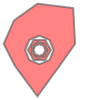

In [146]:
wkt.loads(GEOMETRIES[3])

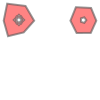

In [148]:
wkt.loads(GEOMETRIES[7])

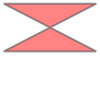

In [149]:
wkt.loads(GEOMETRIES[9])

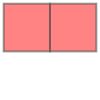

In [151]:
wkt.loads(GEOMETRIES[12])

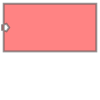

In [152]:
wkt.loads(GEOMETRIES[15])

## https://clydedacruz.github.io/openstreetmap-wkt-playground/